## **Regularization of curves**

This code is designed for problem statement 1: Regularization of curves, both isolated and fragmented curves, for the Adobe GenSolve hackathon.

The test cases provided for this task are as follows:


*   frag0.csv
*   frag1.csv
*   frag2.csv
*   isolated.csv



Install Dependencies

In [ ]:
pip install opencv-python numpy scikit-learn matplotlib scipy svgwrite

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 2.8 MB/s eta 0:00:00


Import Libraries

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

Utility functions

In [ ]:
def combine_subpaths(paths):
    combined_subpath = []
    # Iterate through each path
    for path in paths:
        # Iterate through each subpath in the path
        for subpath in path:
            # Flatten and extend the subpath into the combined list
            for points in subpath:
                combined_subpath.append(points)
    # Convert to a numpy array
    combined_subpath = np.array(combined_subpath)
    # Wrap the combined subpath inside a list of subpaths to match the structure of the input
    return [combined_subpath]



def read_csv(csv_path):
    """
    Read CSV for the given points (provided from GenSolve)
    """
    data = np.genfromtxt(csv_path, delimiter=',')
    paths = {}
    for row in data:
        path_id, sub_path_id, x, y = row
        if path_id not in paths:
            paths[path_id] = {}
        if sub_path_id not in paths[path_id]:
            paths[path_id][sub_path_id] = []
        paths[path_id][sub_path_id].append((x, y))
    return paths


def dict_to_numpy_combined(polylines):
    """
    Convert all the points into a single numpy array for clustering using DBscan
    Returns: [(x1, y1),(x2, y2)]
    """
    path_XYs = []
    for path_id in sorted(polylines.keys()):
        sub_paths = []
        for sub_path_id in sorted(polylines[path_id].keys()):
            XY = np.array(polylines[path_id][sub_path_id])
            if XY.shape[1] >= 2:
                sub_paths.append(XY)
            else:
                print(f"Skipped malformed data: {XY}")
        path_XYs.extend(sub_paths)  # Flatten into a single list of arrays
    return np.vstack(path_XYs)  # Combine all arrays into one


def dict_to_numpyarray(polylines):
    """
    convert the polyline dictionary into a numpy array containg all the paths and subpaths
    """
    path_XYs = []  # init empty list to store the formatted paths
    # iterate over each path_id in the dictionary, sorted by the path_id
    for path_id in sorted(polylines.keys()):
        sub_paths = []  # init empty list to store the sub-paths for the current path_id
        # iterate over each sub_path id in the current path_id, sorted by the sub_path_id
        for sub_path_id in sorted(polylines[path_id].keys()):
            # convert the list of (x,y) tuples into a NumPy array
            XY = np.array(polylines[path_id][sub_path_id])
            # check if the array has atleast two columns (x and y)
            if XY.shape[1] >= 2:
                # if valid, append the numpy array to the sub_paths list
                sub_paths.append(XY)
            else:
                print(f"Skipped malformed data: {XY}")
        path_XYs.append(sub_paths)
    return path_XYs




**DBSCAN Clustering**

Shapes are extracted from the combined set of polylines using DBSCAN clustering. This allows to distinguish collection of shapes that are together e.g. a line inside a circle from the ones that are far apart e.g. a rectanle and a star with some distance in between.

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is a clustering algorithm that identifies clusters based on the density of data points. It works by marking points as core points if they have a minimum number of neighboring points within a specified radius (ε). Clusters are formed by connecting core points and their neighbors, while points that do not meet the density criteria are considered noise. DBSCAN can discover clusters of arbitrary shape, does not require specifying the number of clusters beforehand, and is effective at handling noise and outliers in the data.

After the points are clustered, the paths containing those points are extracted from the polylines. Every cluster can be considered as a single shape.



Overlaps are detected inside a cluster by checking if within a cluster, a point of a particular path is very close (lesser than a threshold) to another point in a different path or subpath within the same cluster.

The path with the maximum overlapping points is the occluded path that is to be completed, because it has overlapping points with all the different paths occlude it. The occluded path is extracted for completion

In [ ]:
plotcolors = [
    "#FF0000",  # Red
    "#00FF00",  # Green
    "#0000FF",  # Blue
    "#FFFF00",  # Yellow
    "#800080",  # Purple
    "#FF7F00",  # Orange
    "#FFC0CB",  # Pink
    "#A52A2A",  # Brown
    "#808080",  # Gray
    "#008080",  # Teal
    "#E6E6FA",  # Lavender
    "#808000",  # Olive
    "#800000",  # Maroon
    "#000080",  # Navy
    "#40E0D0",  # Turquoise
    "#FF7F50",  # Coral
    "#00FF7F",  # Spring Green
    "#FFD700",  # Gold
    "#C0C0C0",  # Silver
    "#FF00FF",  # Magenta
    "#8B0000",  # Dark Red
    "#2E8B57",  # Sea Green
    "#DAA520",  # Goldenrod
    "#4B0082",  # Indigo
    "#00CED1",  # Dark Turquoise
    "#9400D3",  # Dark Violet
    "#FF1493",  # Deep Pink
    "#708090",  # Slate Gray
    "#8B4513",  # Saddle Brown
    "#556B2F",  # Dark Olive Green
    "#6A5ACD",  # Slate Blue
    "#4682B4",  # Steel Blue
    "#FF6347",  # Tomato
    "#7FFF00",  # Chartreuse
    "#D2691E"  # Chocolate
]


def extract_clusters(polylineNDArray):
    """
    Extract point clusters (shapes) from the polylines using DBscan
    """
    # Step 3: Apply DBSCAN clustering
    db = DBSCAN(eps=7, min_samples=10).fit(polylineNDArray)  # create DBSCAN clustering object and fit to X
    core_samples_mask = np.zeros_like(db.labels_,
                                      dtype=bool)  # create a boolean mask with the same size as the labels array filled with zeros to identify core samples later
    core_samples_mask[
        db.core_sample_indices_] = True  # sets the elements of the core_samples_mask corresponding to core samples
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    clustered_data = []

    # Step 4: Visualization
    unique_labels = set(labels)
    # firstly assign a plotcolor value to each unique label as a dictionary
    # for k, col in zip(unique_labels, plotcolors):
    for k in unique_labels:
        # creates a mask that selects points beloging to the current cluster k
        class_member_mask = (labels == k)

        # core_samples_mask is a boolean array indicating the points which beling to the current cluster k
        # performs element-wise logical AND between the two masks, meaning only the points belonging to both
        # the current cluster and the core samples are selected
        # resulting data points are assigned to xy
        xy = polylineNDArray[class_member_mask & core_samples_mask]
        clustered_data.append([k, xy])

    print(f"Number of clusters detected: {n_clusters_}")
    return clustered_data


def visualize_clusters(clusterlist):
    """
    plot the list of clusters extracted using DBscan
    """
    num_clusters = len(clusterlist)
    # zip the labels with the colors
    for k, color in zip(clusterlist, plotcolors):
        label, cluster_points = k

        # remove the noise from the count of the number of clusters
        if label == -1:
            num_clusters -= 1
            color = "black"  # black color is used for the noise

        plt.plot(cluster_points[:, 0], cluster_points[:, 1], 'o', markerfacecolor=color,
                 markeredgecolor='k',
                 markersize=6)

    plt.title(f'Number of clusters: {num_clusters}')
    plt.show()


def clusters_from_polylines(polyline_np_array, clusters):
    """
    Extract the clusters from the given polylines.
    Args:
        polyline_np_array (numpy array of polylines) and clusters (list of detected clusters)
    Returns:
        extracted_clusters = [[[(x1, y1), (x2, y2)]]]
    """
    # first create a list for the clusters to be extracted
    extracted_clusters = []
    for _, cluster_data in enumerate(clusters):
        cluster_id, cluster_points = cluster_data
        # skip including for the noise cluster
        if cluster_id == -1:
            continue
        extracted_clusters.append([])
        # we put the entire path into the cluster in this case
        for path_index, path in enumerate(polyline_np_array):
            path_added = False  # flag to indicate if the path was added as an extracted cluster
            # if a point in the path exists in the cluster, put the entire path into the cluster
            # and move on to the next path
            for subpath_idex, subpath in enumerate(path):
                for point_index, point in enumerate(subpath):
                    if np.any(np.all(point == cluster_points, axis=1)):
                        extracted_clusters[cluster_id].append(path)
                        path_added = True
                        break
                if path_added:
                    break
    return extracted_clusters

**Plotting functions**

In [ ]:
def plot_paths_numpy(paths, figname="plot"):
    """
    Plot polylines from NumPy array of polylines
    Args:
        paths: NumPy array of paths
    """
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    if figname is not None:
        fig.suptitle(figname)

    for path_id, path in enumerate(paths):
        color = plotcolors[int(path_id) % len(plotcolors)]
        for sub_path_id, subpath in enumerate(path):
            ax.plot(subpath[:, 0], subpath[:, 1], c=color, linewidth=2)
    ax.set_aspect('equal')
    plt.show()


def image_from_numpyarray(path_XYs):
    """
    Create a single channel edge image for the given formatted polyline numpy array.
    """
    max_x, max_y = 0, 0
    # Ensure only valid arrays are processed
    for XYs in path_XYs:
        for XY in XYs:
            if XY.shape[1] >= 2:  # Check if XY has at least two columns (x and y)
                max_x = max(max_x, int(np.max(XY[:, 0])))
                max_y = max(max_y, int(np.max(XY[:, 1])))

    # Create a blank image
    image = np.zeros((max_y + 10, max_x + 10, 3), dtype=np.uint8)

    # Draw the shapes on the image
    for XYs in path_XYs:
        for XY in XYs:
            if XY.shape[1] >= 2:  # Ensure valid XY arrays are processed
                points = np.array([(x, y) for x, y in XY], np.int32)
                points = points.reshape((-1, 1, 2))
                cv2.polylines(image, [points], isClosed=False, color=(255, 255, 255), thickness=2)

    return image


def visualize_clusters(clusterlist):
    """
    plot the list of clusters extracted using DBscan
    """
    num_clusters = len(clusterlist)
    # zip the labels with the colors
    for k, color in zip(clusterlist, plotcolors):
        label, cluster_points = k

        # remove the noise from the count of the number of clusters
        if label == -1:
            num_clusters -= 1
            color = "black"  # black color is used for the noise

        plt.plot(cluster_points[:, 0], cluster_points[:, 1], 'o', markerfacecolor=color,
                 markeredgecolor='k',
                 markersize=6)

    plt.title(f'Number of clusters: {num_clusters}')
    plt.show()


**Detector Functions**

Circle Detector Function:

Circles are identified within a set of polylines using the Hough Circle Transform. First, it converts the polylines into an image and then to grayscale. The grayscale image is blurred to reduce noise, making circle detection more accurate. The Hough Circle Transform is then applied, which works by identifying circular shapes based on the gradient information in the image. It returns the parameters (center coordinates and radius) of detected circles.

In [ ]:
def detect_circles(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # if img is None:
    #     raise ValueError(f"Image at path {image_path} could not be read.")
    img = cv2.medianBlur(img, 5)
    circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT, 1, 30, param1=100, param2=30, minRadius=60, maxRadius=500)
    print(circles)
    return circles

Star Detector Functions

First, the input image is converted to grayscale and thresholded to create a binary image where contours can be detected. The contours of the binary image are then found using OpenCV's findContours function. Each detected contour is analyzed to determine if it resembles a star shape by checking if it has a sufficient number of vertices (typically 10 or more). To further validate the star shape, the contour is fitted with a regular star shape by calculating its center and radius, then generating a star with specified points and size. If a contour matches these criteria, it is classified as a star, and the contour is drawn on the image for visualization.

In [ ]:
def detect_contours(im):
    imgray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    _, imgray = cv2.threshold(imgray, 100, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(imgray, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    return contours

# Function to create a regular star shape
def create_star(center, size, points=5):
    angle_step = 2 * np.pi / points
    angles = np.linspace(0, 2 * np.pi, 2 * points, endpoint=False)
    radii = np.tile([size, size / 2], points)
    x = center[0] + radii * np.cos(angles)
    y = center[1] + radii * np.sin(angles)
    return np.vstack((x, y)).astype(np.int32).T

def star_points_to_polylines(adjusted_star_points):
    if len(adjusted_star_points) > 0:
        # Reshape the star points to the required polyline format
        polyline = adjusted_star_points.reshape(-1, 2)
        # Append the first point to the end to close the polyline
        polyline = np.append(polyline, [polyline[0]], axis=0)
        return [polyline]
    return []

# Function to fit a regular star to the detected contour
def fit_star_to_contour(contour, points=5):
    moments = cv2.moments(contour)
    if moments['m00'] == 0:
        return np.array([])  # Avoid division by zero
    center_x = int(moments['m10'] / moments['m00'])
    center_y = int(moments['m01'] / moments['m00'])
    center = (center_x, center_y)
    distances = np.sqrt((contour[:, 0, 0] - center_x) ** 2 + (contour[:, 0, 1] - center_y) ** 2)
    size = int(np.max(distances))
    star = create_star(center, size, points)
    return star

def is_star(contour):
    # Calculate the perimeter of the contour
    perimeter = cv2.arcLength(contour, True)
    # Approximate the shape
    approx = cv2.approxPolyDP(contour, 0.04 * perimeter, True)

    # Check if the contour has 10 or more points (stars typically have many points)
    if len(approx) >= 10:
        return True
    return False

def check_star(image):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply GaussianBlur to reduce noise and improve contour detection
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    # Apply binary thresholding
    _, threshold = cv2.threshold(blurred, 60, 255, cv2.THRESH_BINARY)
    # Find contours in the threshold image
    contours, _ = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        if is_star(contour):
            # Draw the contour
            cv2.drawContours(image, [contour], -1, (0, 255, 0), 2)
            print("Star shape detected!")
            return contour, image
    return None, None

**Rectangle Detector Functions**

First, the image is converted to grayscale, blurred to reduce noise, and then thresholded to create a binary image. Contours are extracted from this binary image to identify potential shapes. Each contour is approximated to a polygon, and rectangles are specifically identified by checking if the polygon has four vertices. To ensure the detected shape is a rectangle, its aspect ratio is checked to be within a predefined range. If these criteria are met, the rectangle's coordinates are stored. Finally, the detected rectangles are converted into polylines, where each rectangle is represented as a series of connected lines, and this representation is returned for further processing or visualization.

In [ ]:
def detect_rectangles2(im):
    # Convert the image to grayscale
    imgray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    # Apply GaussianBlur to reduce noise and improve edge detection
    blurred = cv2.GaussianBlur(imgray, (5, 5), 0)
    # Threshold the grayscale image
    _, thresh = cv2.threshold(blurred, 100, 255, cv2.THRESH_BINARY)
    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # Define the aspect ratio thresholds for detecting rectangles
    aspect_ratio_min = 0.8
    aspect_ratio_max = 1.2
    # To store detected rectangles
    detected_rectangles = []
    # Iterate through the contours
    for contour in contours:
        # Approximate the contour to a polygon
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        # Check if the polygon has 4 vertices
        if len(approx) == 4:
            # Get the bounding box directly from the approx points
            x_min, y_min = np.min(approx[:, 0, :], axis=0)
            x_max, y_max = np.max(approx[:, 0, :], axis=0)

            # Define the points of the rectangle
            rect_points = np.array([
                [x_min, y_min],
                [x_max, y_min],
                [x_max, y_max],
                [x_min, y_max],
                [x_min, y_min],
            ], dtype=np.int32)
            # Check aspect ratio and add the rectangle points if it meets the criteria
            w, h = x_max - x_min, y_max - y_min
            aspect_ratio = float(w) / h
            if aspect_ratio_min < aspect_ratio < aspect_ratio_max:
                detected_rectangles.append(rect_points)
                break

    return detected_rectangles


def rectangles_to_polylines2(detected_rectangles):
    """
    Converts detected rectangles into polylines.
    Args:
        detected_rectangles: List of detected rectangles (as numpy arrays of points).
    Returns:
        polylines: List of polylines where each polyline represents a rectangle.
    """
    polylines = []

    for rect in detected_rectangles:
        polyline = np.array(rect, dtype=np.float32)
        print(polyline)
        polylines.append(polyline)

    return [polylines]


**Line Detection using Hough Line Transformation**

First, the input image or numpy array is converted to grayscale, and the image is prepared for line detection. The Probabilistic Hough Line Transform is then applied to identify lines in the grayscale image. Detected lines are represented as pairs of endpoints, and these lines are drawn on a color image for visualization. To refine the results, close lines are filtered out by calculating the distance between each pair of lines and removing lines that are too close to each other. This ensures that only distinct and meaningful lines are retained. The function returns the filtered lines and the image with the detected lines overlaid.

In [ ]:
def detect_line_Probabilistic_Hough_Tranform(polylines_np_array, img=None):
    """
    Probabilistic Hough Line Transform
    """
    if img is None:
        raw = image_from_numpyarray(polylines_np_array)
    else:
        raw = img
    gray_img = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)      # convert the raw image to gray image
    # dst = cv2.Canny(raw, 50, 200, None, 3)             # applies the canny edge detector to the image with a threshold value of 50 and 200
    cdstP = cv2.cvtColor(gray_img, cv2.COLOR_GRAY2BGR)    # converts the grayscale edge image to a BGR image cdst for displaying colored lines
    detected_Polylines = []
    # probabilistic Hough Line transform
    linesP = cv2.HoughLinesP(gray_img, 1, np.pi / 180, 50, None, 50, 10)
    if linesP is not None:
        for i in range(0, len(linesP)):
            l = linesP[i][0]
            pt1 = (l[0], l[1])
            pt2 = (l[2], l[3])
            detected_Polylines.append([[pt1, pt2]])
            cv2.line(cdstP, pt1, pt2, 255, 3, cv2.LINE_AA)
    return np.array(detected_Polylines), cdstP



def remove_close_lines(detected_polylines, distance_threshold=5.0):
    """
    Removes paths containing lines that are very close to one another.
    """

    def line_distance(line1, line2):
        def point_line_distance(point, line):
            px, py = point
            x1, y1, x2, y2 = line
            dx, dy = x2 - x1, y2 - y1
            if dx == dy == 0:  # line is a point
                return np.hypot(px - x1, py - y1)
            t = ((px - x1) * dx + (py - y1) * dy) / (dx * dx + dy * dy)
            if t < 0:
                return np.hypot(px - x1, py - y1)
            elif t > 1:
                return np.hypot(px - x2, py - y2)
            return np.hypot(px - (x1 + t * dx), py - (y1 + t * dy))

        p1_dist = point_line_distance(line1[:2], line2)
        p2_dist = point_line_distance(line1[2:], line2)
        q1_dist = point_line_distance(line2[:2], line1)
        q2_dist = point_line_distance(line2[2:], line1)
        return min(p1_dist, p2_dist, q1_dist, q2_dist)

    filtered_polylines = []
    for i, line1 in enumerate(detected_polylines):
        keep_line = True
        # Extract the line's coordinates for easier processing
        print(f"line:{i}", line1)
        line1_coords = [line1[0][0][0], line1[0][0][1], line1[0][1][0], line1[0][1][1]]
        for j, line2 in enumerate(filtered_polylines):
            line2_coords = [line2[0][0][0], line2[0][0][1], line2[0][1][0], line2[0][1][1]]
            if line_distance(line1_coords, line2_coords) < distance_threshold:
                keep_line = False
                break
        if keep_line:
            filtered_polylines.append(line1)

    return filtered_polylines

**Utility functions for fragmented shapes**

The check_points_within_radius function evaluates whether the majority of points in a given path fall within the radius of detected circles. It does this by iterating through each subpath and checking if each point is inside any of the circles. If more than half of the points in a subpath are within the radius of a circle, the function returns True, indicating that the path is considered to be within the circles. If not, it returns False.

The remove_overlapping_points_and_separate_paths function processes a list of paths by modifying points that are close to the circumference of detected circles. Points near the circle's edge are snapped to the circle's radius, while points that are far from the previous point in the path are used to start a new path. The function returns a list of modified paths, with points either adjusted for proximity to circles or separated into distinct paths if they are too distant from each other.

The circles_to_polyline function converts detected circles into a polyline format. For each circle, it generates a series of points around the circle's perimeter to approximate it as a polyline. By specifying the number of points, the function controls the smoothness of the polyline representation. The resulting list contains subpaths where each subpath represents the points forming the boundary of a circle.

In [ ]:
def check_points_within_radius(path, circles, threshold=0.001):
    """
    Checks if a majority of points in the path lie within the radius of the detected circles.
    If the majority of points lie within the radius, returns True; otherwise, returns False.

    Args:
        path: A list containing one or more subpaths.
        circles: Detected circles returned by the detect_circles function.
        threshold: The threshold to decide whether points lying within the radius are acceptable.

    Returns:
        bool: True if the majority of points lie within the radius, otherwise False.
    """
    if circles is None:
        return True  # If no circles are detected, return True as there are no points to check against

    for subpath in path:
        total_points = len(subpath)
        points_within_radius = 0

        for point in subpath:
            x, y = point

            for circle in circles[0, :]:
                circle_x, circle_y, radius = circle
                distance = np.sqrt((x - circle_x) ** 2 + (y - circle_y) ** 2)

                if distance < radius:
                    # Point lies within the radius of the circle
                    points_within_radius += 1
                    break  # No need to check other circles for this point

        # Check if the majority of points lie within the radius
        if points_within_radius / total_points > 0.5:
            return True

    return False  # Majority of points do not lie within the radius



def remove_overlapping_points_and_separate_paths(path, circles, tolerance=8.0, distance_threshold=20.0):
    """
    Modifies points near the circumference of detected circles by snapping them to the circle's radius.
    Separates points into different paths if they are far away from the last point.

    Args:
        path: A list containing one or more subpaths.
        circles: Detected circles returned by the detect_circles function.
        tolerance: A small value that defines the thickness of the band around the circle's radius
                   where points are considered overlapping.
        distance_threshold: The distance threshold to decide whether to start a new path.

    Returns:
        modified_paths: A list of paths where points near circles are snapped to the circle's radius.
                        If points are far apart, they are placed in different paths.
    """
    if circles is None:
        return path  # If no circles are detected, return the original path

    modified_paths = []
    current_path = []

    for subpath in path:
        for i, point in enumerate(subpath):
            x, y = point
            point_modified = False

            for circle in circles[0, :]:
                circle_x, circle_y, radius = circle
                distance = np.sqrt((x - circle_x) ** 2 + (y - circle_y) ** 2)

                # Check if the point is near the circumference within the tolerance range
                if abs(distance - radius) <= tolerance:
                    # Point is near the circle; it will not be added to the current path
                    point_modified = True
                    break

            if not point_modified:
                if len(current_path) > 0:
                    last_x, last_y = current_path[-1]
                    point_distance = np.sqrt((x - last_x) ** 2 + (y - last_y) ** 2)

                    # If the point is far from the last point, start a new path
                    if point_distance > distance_threshold:
                        modified_paths.append(np.array(current_path))
                        current_path = []

                current_path.append([x, y])

        if len(current_path) > 0:
            modified_paths.append(np.array(current_path))
            current_path = []

    return modified_paths


def circles_to_polyline(detected_circles, num_points=10000):
    """
    Converts detected circles into a polyline format with paths and subpaths.
    Args:
        detected_circles: Detected circles from Hough Transform, in the format [x, y, radius].
        num_points: Number of points to approximate the circle. Higher numbers give a smoother polyline.
    Returns:
        polylines: A list of paths, where each path corresponds to a detected circle.
    """
    polylines = []
    for circle in detected_circles[0, :]:
        a, b, r = circle[0], circle[1], circle[2]
        subpath = []
        for i in range(num_points):
            theta = np.deg2rad(i * 360 / num_points)
            x = int(a + r * np.cos(theta))
            y = int(b + r * np.sin(theta))
            subpath.append((x, y))
        subpath = np.array(subpath)
        polylines.append([subpath])
    return polylines


**File Upload**

This code is designed for Problem Statement 1: Regularizing Curves

Test case files for Problem statement 1 are:

*   frag0.csv
*   frag1.csv
*   frag2.csv
*   isolated.csv

Upload your file and specify the location here.

In [ ]:
csv_file = read_csv('/content/frag1.csv')

In [ ]:
# Read the CSV and convert to numpy array
points_numpy_combined = dict_to_numpy_combined(csv_file)
# Extract clusters from the points
clusters = extract_clusters(points_numpy_combined)
# Convert dictionary to numpy array for polylines
polylines_numpy = dict_to_numpyarray(csv_file)
clustered_polylines = clusters_from_polylines(polylines_numpy, clusters)

Number of clusters detected: 2


**Visualzing clusters**
Ignore if you do not want to visualize individual clusters.

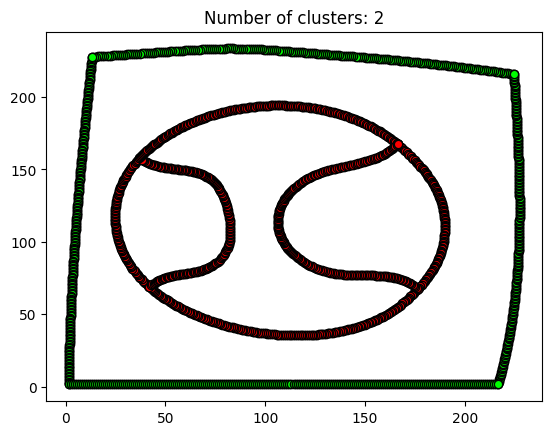

In [ ]:
visualize_clusters(clusters)

Detect shapes within the curve and regularize them for every cluster detected.

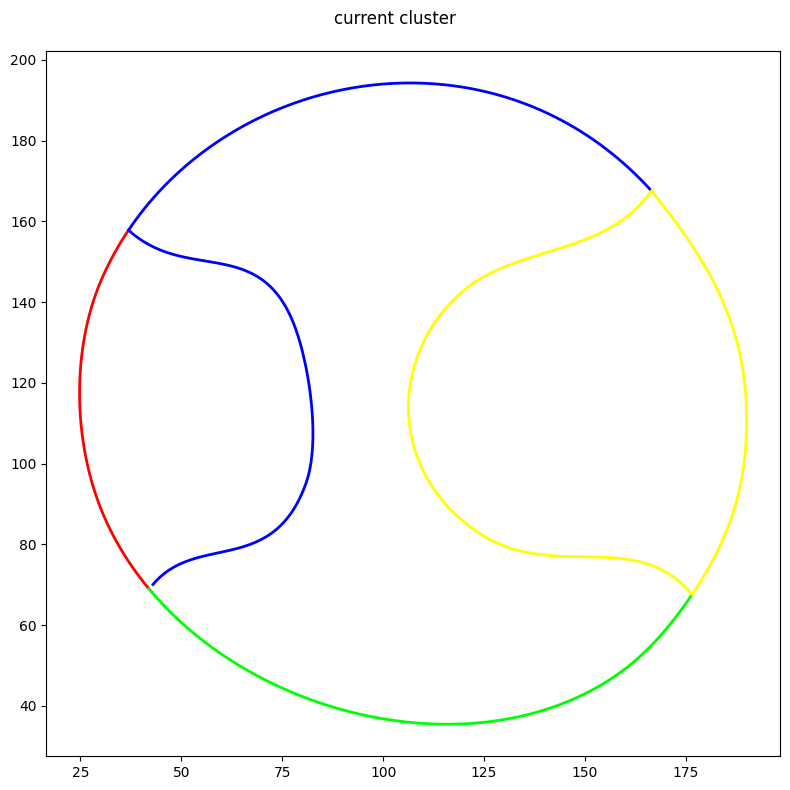

[[[107.5 113.5  81.4]]]


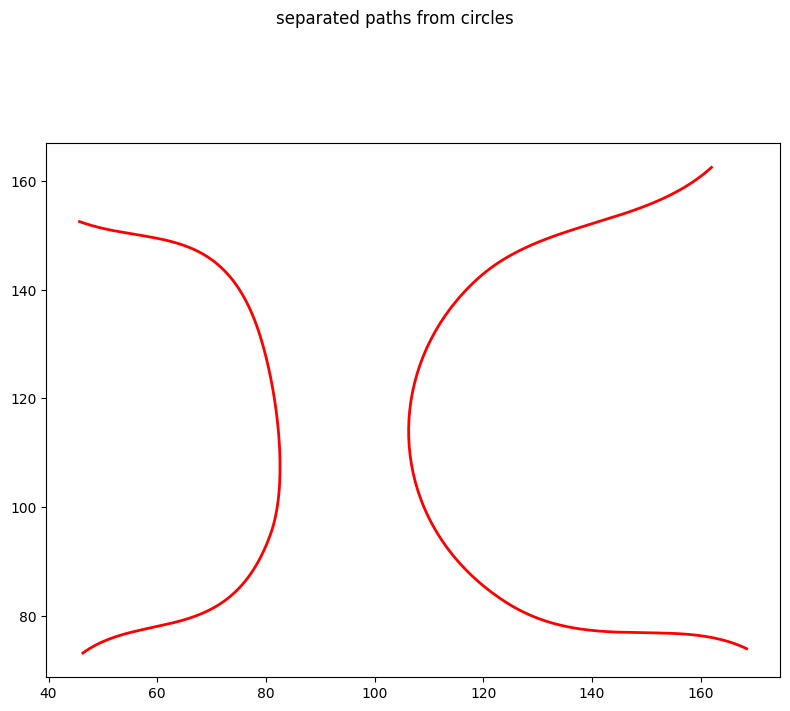

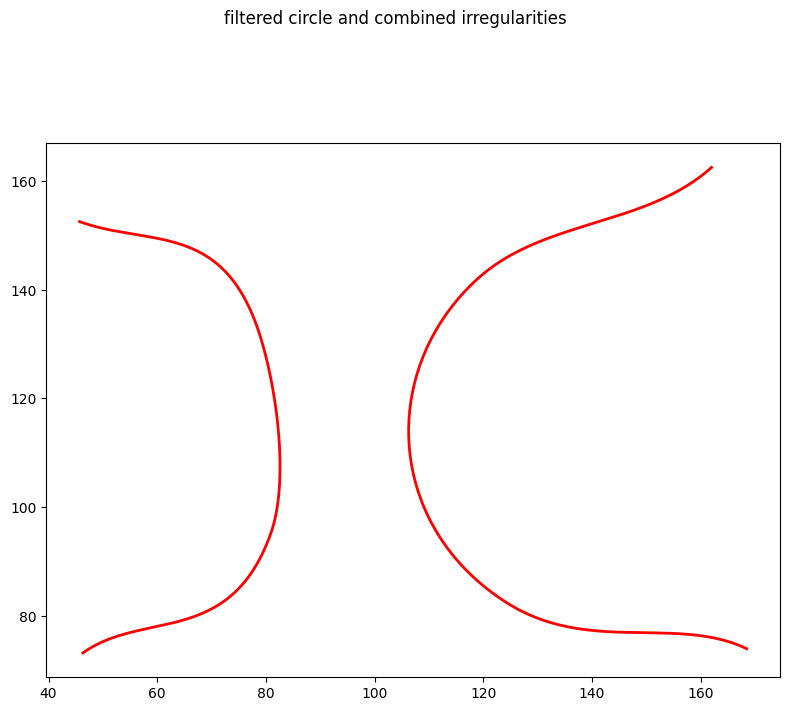

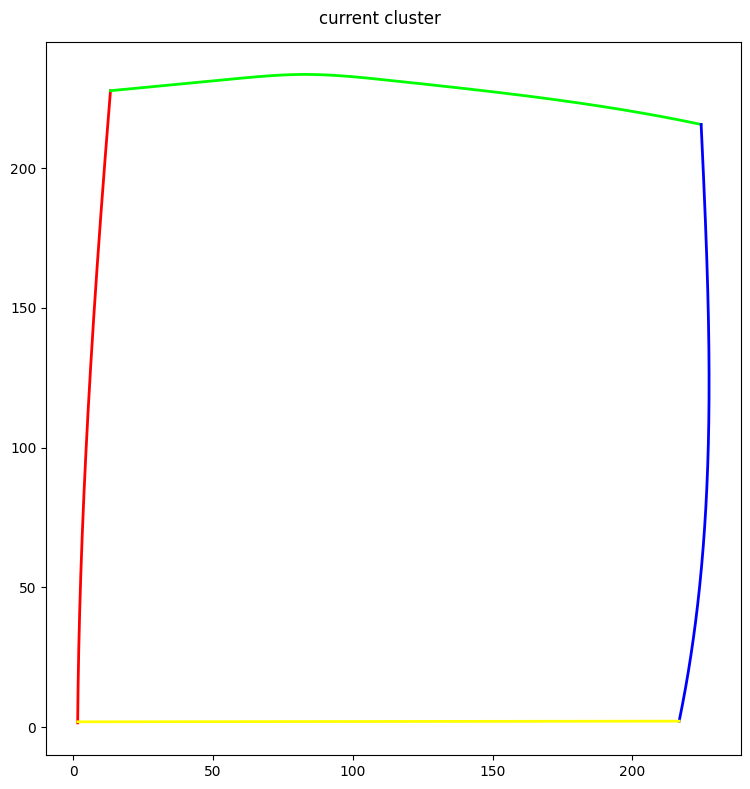

None
[[  0.   0.]
 [225.   0.]
 [225. 229.]
 [  0. 229.]
 [  0.   0.]]


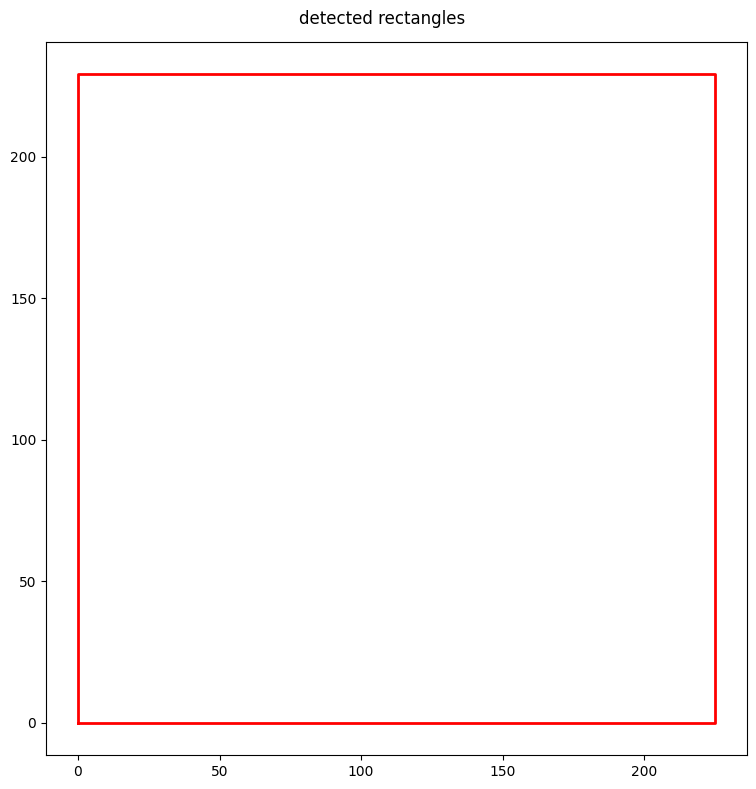

In [ ]:
combined_polylines = []
# Process each cluster
for i, shape in enumerate(clustered_polylines):
    if shape:
        plot_paths_numpy(shape, "current cluster")
        image = image_from_numpyarray(shape)
        # cv2.imshow(f"Generated Image for cluster {i}", image)
        # Detect circles
        circles = detect_circles(image)
        if circles is not None:
            # output_image_path = f"shape_{i}_with_circles.png"
            # circle.draw_circles_on_image(image, circles, output_image_path)
            # cv2.imshow(f"Shape {i} with Circles", image)
            combined_subpaths = combine_subpaths(shape)
            paths_inside = check_points_within_radius(combined_subpaths, circles)
            if paths_inside:
                separated_paths = remove_overlapping_points_and_separate_paths(combined_subpaths, circles)
                if separated_paths is not None:
                    combined_polylines.append(separated_paths)
                    plot_paths_numpy([separated_paths], "separated paths from circles")
                plot_paths_numpy(combined_polylines, "filtered circle and combined irregularities")
            circle_polyline = circles_to_polyline(circles)
            combined_polylines.extend(circle_polyline)
            continue        # once the shape is detected and confirmed do not test for the other shapes
        # star detection
        stars, star_img = check_star(image)
        if star_img is not None:
            contours = detect_contours(image)
            regular_star = fit_star_to_contour(contours[0], 5) if contours else []
            if len(regular_star) == 0:
                print("No valid star shape detected.")
            else:
                x_min, y_min = np.min(regular_star, axis=0)
                x_max, y_max = np.max(regular_star, axis=0)
                star_width = x_max - x_min
                star_height = y_max - y_min
                padding = 50
                image_width = star_width + 2 * padding
                image_height = star_height + 2 * padding
                image_size = (image_height, image_width)
                adjusted_star_points = regular_star - [x_min - padding, y_min - padding]
                star_polylines = star_points_to_polylines(adjusted_star_points)
                print(f"star polylines", star_polylines)
                plot_paths_numpy([star_polylines])
                combined_polylines.append(star_polylines)
            continue
        # rectangle detection
        rectangles = detect_rectangles2(image)
        if rectangles:
            rectangle_polylines = rectangles_to_polylines2(rectangles)
            combined_polylines.extend(rectangle_polylines)
            plot_paths_numpy(rectangle_polylines, "detected rectangles")
            continue
        # line detection finally
        lines, linesImg = detect_line_Probabilistic_Hough_Tranform(shape)
        if lines is not None:
            print(lines)
            filtered_lines = remove_close_lines(lines)
            plot_paths_numpy(filtered_lines, "detected lines")
            combined_polylines.extend(filtered_lines)
            continue


**Combining the clustered regularized polylines**

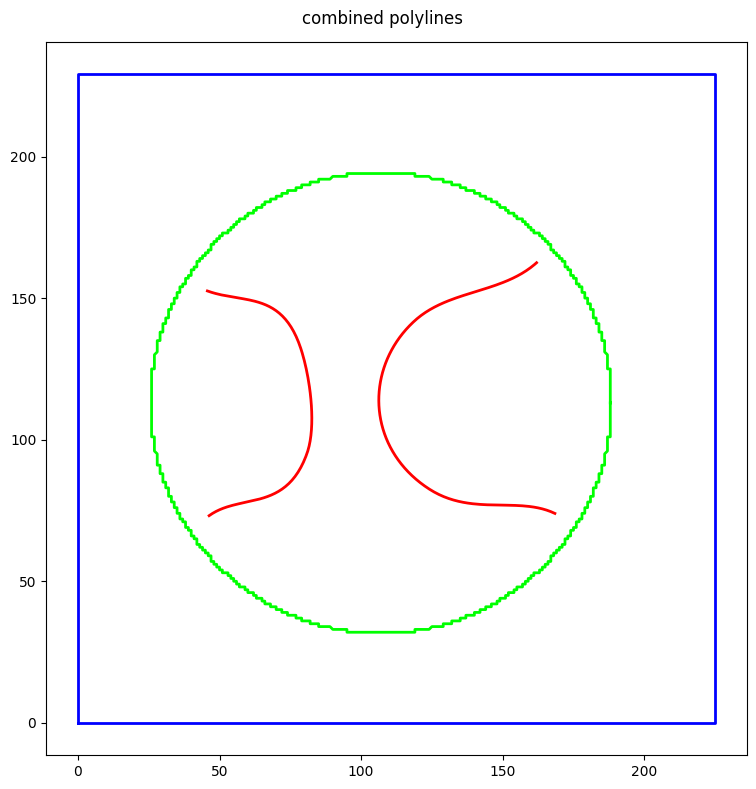

In [ ]:
plot_paths_numpy(combined_polylines, "combined polylines")
cv2.waitKey(0)
cv2.destroyAllWindows()

Convert the polylines back to svg format

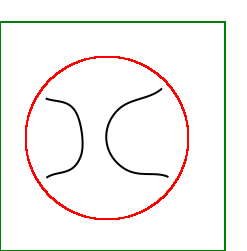

In [28]:
import svgwrite
from IPython.display import SVG, display

def polylines_to_svg(paths_XYs, svg_path):
    """
    Converts a list of polylines (paths_XYs) to an SVG image and saves it.
    Args:
        paths_XYs (list): List of numpy arrays, where each array represents a polyline with coordinates.
        svg_path (str): Path to save the SVG image.
    """
    # Calculate the bounding box of the image
    W, H = 0, 0
    for path_XYs in paths_XYs:
        for XY in path_XYs:
            W = max(W, np.max(XY[:, 0]))
            H = max(H, np.max(XY[:, 1]))

    padding = 0.1
    W = int(W + padding * W)
    H = int(H + padding * H)

    # Create a new SVG drawing
    dwg = svgwrite.Drawing(svg_path, size=(W, H), profile='tiny')

    colours = ['black', 'red', 'green', 'blue', 'yellow', 'cyan', 'magenta']  # Add more colors if needed

    for i, path in enumerate(paths_XYs):
        path_data = []
        c = colours[i % len(colours)]
        for XY in path:
            # Adjust the Y-coordinate to prevent mirroring
            adjusted_XY = XY.copy()
            adjusted_XY[:, 1] = H - adjusted_XY[:, 1]
            # Move to the first point
            path_data.append(("M", (adjusted_XY[0, 0], adjusted_XY[0, 1])))
            # Draw lines to the subsequent points
            for j in range(1, len(adjusted_XY)):
                path_data.append(("L", (adjusted_XY[j, 0], adjusted_XY[j, 1])))
        # Convert path data to string format suitable for SVG
        path_str = " ".join(f"{cmd}{x},{y}" for cmd, (x, y) in path_data)
        # Add the path to the SVG drawing
        dwg.add(dwg.path(d=path_str, fill='none', stroke=c, stroke_width=2))

    # Save the SVG file
    dwg.save()

    # Finally display the file in the notebook
    display(SVG(svg_path))


polylines_to_svg(combined_polylines, '/content/completed_regularization.svg')